Import des librairies et données nécessaires à l'étude:
===

In [2]:
# Librairies de calcul:
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Librairies de visualisation:
import matplotlib.pyplot as plt
import seaborn as sns

# Options globales pour l'output display:
pd.options.display.float_format = "{:.2f}".format
colors = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]

# Import des donnees:
Transactions_df = pd.read_csv("transactions.csv" , sep=";")
Customers_df = pd.read_csv("customers.csv", sep=";")
Products_df = pd.read_csv("products.csv" , sep=";")

/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_82583/4178317299.py:18: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  Transactions_df = pd.read_csv("transactions.csv" , sep=";")


Observation et nettoyage des Dataframes:
===

Transactions_df:
---

In [5]:
Transactions_df.info()
Transactions_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     687534 non-null  object
 1   date        687534 non-null  object
 2   session_id  687534 non-null  object
 3   client_id   687534 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


,id_prod,date,session_id,client_id
count,687534,687534,687534,687534
unique,3265,687419,345505,8600
top,1_369,2021-10-06 21:29:59.752585,s_118668,c_1609
freq,2340,2,14,25586


In [6]:
Transactions_df.loc[(Transactions_df["id_prod"]=="T_0"),("session_id","date","client_id")].describe()

,session_id,date,client_id
count,0,0,0
unique,0,0,0
top,NaN,NaN,NaN
freq,NaN,NaN,NaN


In [7]:
Products_df.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

- Pas de valeurs nulles.
- On remarque des "test_2021*" qui ont tous le même id_prod et session_id (T_0 et s_0 respectivement), les client_id sont ct_0 (femme née en 2001) et ct_1 (homme née en 2001). Le produit T_0 à un prix négatif de -1€. 200 lignes sont concernées. On peut considérer qu'il s'agit de comptes de test faisant des transactions fictives dans le but de tester le site lors de son lancement. Les 200 lignes doivent être supprimées du dataframe. Il faudra aussi supprimer les deux faux clients et le produit fictif. Cependant il nous sera possible de revenir en arrière s'il s'avère qu'il ne s'agissait pas de tests.

In [9]:
Transactions_df.drop(Transactions_df[(Transactions_df["id_prod"] == "T_0")].index, inplace=True)
Transactions_df["date"] = pd.to_datetime(Transactions_df["date"], yearfirst= True)

In [10]:
Transactions_df.info()
Transactions_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687534 non-null  object        
 1   date        687534 non-null  datetime64[ns]
 2   session_id  687534 non-null  object        
 3   client_id   687534 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 32.0+ MB


,date
count,687534
mean,2022-03-01 21:24:00.618519296
min,2021-03-01 00:01:07.843138
25%,2021-09-10 10:35:20.642323456
50%,2022-02-27 06:50:25.400120064
75%,2022-08-28 22:16:49.841665536
max,2023-02-28 23:58:30.792755


- Les 200 lignes "test" ont bien été suprimées de notre dataframe.
- Les date sont bien lues en datetime.
- Dates du fuuutuuuure

Customers_df:
---

In [13]:
Customers_df.info()
Customers_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


,birth
count,8621.00
mean,1978.28
std,16.92
min,1929.00
25%,1966.00
50%,1979.00
75%,1992.00
max,2004.00


In [14]:
Customers_df.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

- Pas de valeurs manquantes
- Pas de valeurs aberrentes dans les années de naissance (min 2004 = 17 ans et max 1929 = 92 ans)
- On veut une colonne supplémentaire avec l'âge du client
- Nous avions décidé de supprimer les clients test (ct_1 et ct_0)

In [16]:
# Suppression des clients tests:
Customers_df.drop(Customers_df[(Customers_df["client_id"] == "ct_0")].index, inplace=True)
Customers_df.drop(Customers_df[(Customers_df["client_id"] == "ct_1")].index, inplace=True)

# Ajout d'une colonne "age" aux clients:
from datetime import datetime
current_year = datetime.now().strftime('%Y')

Customers_df["age"] = int(current_year) - Customers_df["birth"]

# Verifications:
Customers_df.info()
Customers_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
 3   age        8621 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 269.5+ KB


,birth,age
count,8621.00,8621.00
mean,1978.28,46.72
std,16.92,16.92
min,1929.00,21.00
25%,1966.00,33.00
50%,1979.00,46.00
75%,1992.00,59.00
max,2004.00,96.00


Products_df:
---

In [18]:
Products_df.info()
Products_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB


,price,categ
count,3286.00,3286.00
mean,21.86,0.37
std,29.85,0.62
min,0.62,0.00
25%,6.99,0.00
50%,13.07,0.00
75%,22.99,1.00
max,300.00,2.00


In [19]:
Products_df.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

- Pas de valeurs manquantes, les types de données sont bons
- min = -1 correspond à un produit d'identifiant T_0, dans le df transaction nous avions pris la décision de supprimer les transactions en rapport avec ce que l'on suppose être un test.

In [21]:
# Suppression du produit test:
Products_df.drop(Products_df[(Products_df["id_prod"] == "T_0")].index, inplace=True)

# Verifications:
Products_df.info()
Products_df[["price"]].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB


,price
count,3286.00
mean,21.86
std,29.85
min,0.62
25%,6.99
50%,13.07
75%,22.99
max,300.00


Jointure des dataframes:
===

In [24]:
# Verifications d'unicite et recherche de duplicats:
print("Nombre de client_id:", Customers_df["client_id"].nunique())
print("Nombre de id_prod:", Products_df["id_prod"].nunique())

Duplicated_df = Transactions_df.loc[Transactions_df.duplicated()==True]
Duplicated_df.info()

Nombre de client_id: 8621
Nombre de id_prod: 3286
<class 'pandas.core.frame.DataFrame'>
Index: 361040 entries, 687535 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_prod     0 non-null      object        
 1   date        0 non-null      datetime64[ns]
 2   session_id  0 non-null      object        
 3   client_id   0 non-null      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 13.8+ MB


- client_id est une bonne clé pour Customers_df puisqu'il y a 8621 valeurs uniques sur 8621 valeurs au total (cf .describe() plus haut)
- id_prod est une bonne clé pour Products_df puisqu'il y a 3286 valeurs uniques sur 3286 valeurs au total (cf .describe() plus haut)
- La création d'un dataframe duplicate, afin de vérifier l'unicité des transacations, montre que les 679332 transactions répertoriées sont uniques

Ces vérifications faites on peut faire les jointures, on souhaite conserver toutes les informations présentes dans Transactions_df et les lier à celles présentes dans les deux autres dataframes. id_prod et client_id pourront être répétés plusieurs fois dans Transactions_df mais certains produits peuvent ne jamais avoir été vendus où certains clients peuvent ne jamais avoir effectué d'achats on souhaite pourtant conserver leurs informations. On fera une jointure "full outter". On s'attend donc à avoir *in fine* un dataframe avec 679332 lignes minimum (+ produits jamais vendus et clients non acheteurs). Il peut s'agir de clients n'achetant pas sur plusieurs sessions.

In [134]:
Interm_clean = Interm_df.dropna()
Interm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687534 entries, 0 to 687554
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687534 non-null  object        
 1   date        687534 non-null  datetime64[ns]
 2   session_id  687534 non-null  object        
 3   client_id   687534 non-null  object        
 4   sex         687534 non-null  object        
 5   birth       687534 non-null  float64       
 6   age         687534 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 42.0+ MB


In [35]:
# Premiere jointure:
Interm_df = pd.merge(Transactions_df, Customers_df, on="client_id", how="outer")
Interm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048596 entries, 0 to 1048595
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687534 non-null  object        
 1   date        687534 non-null  datetime64[ns]
 2   session_id  687534 non-null  object        
 3   client_id   687555 non-null  object        
 4   sex         687555 non-null  object        
 5   birth       687555 non-null  float64       
 6   age         687555 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 56.0+ MB


In [39]:
# Seconde jointure:
Complet_df = pd.merge(Interm_df, Products_df, on="id_prod", how="outer")
Complet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048617 entries, 0 to 1048616
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687555 non-null  object        
 1   date        687534 non-null  datetime64[ns]
 2   session_id  687534 non-null  object        
 3   client_id   687555 non-null  object        
 4   sex         687555 non-null  object        
 5   birth       687555 non-null  float64       
 6   age         687555 non-null  float64       
 7   price       687555 non-null  float64       
 8   categ       687555 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 72.0+ MB


In [40]:
Complet_df.isna().sum()

id_prod       361062
date          361083
session_id    361083
client_id     361062
sex           361062
birth         361062
age           361062
price         361062
categ         361062
dtype: int64

La première jointure, de Customers_df sur Transactions_df donne le dataframe Interm_df avec 679353 lignes.

La seconde jointure, de Products_df sur Interm_df donne le dataframe Comlpet_df avec 679374 lignes.

Le nombre de NaN est plus important qu'attendu:
- On retrouve 21 clients qui n'ont pas fait d'achats mais qui ont un compte sur notre site.
- On a également 21 produits qui ne se sont jamais vendus mais qui sont présents dans notre référencement.
- Les 242 NaN dans price et categ ne sont pas normaux même en prennant en compte les 21 NaN "corresspondants" aux clients non achateurs. Ils correspondent tous à différentes sessions de différents clients concernant le produit 0_2245 qui ne se retrouve pas dans le Products_df. Il s'agit probablement d'une suppression par inadvertance mais il faudrait ajouter les informations concernant le prix de ce produit, la catégorie étant donnée par la structure de l'identifiant. Pour que nos calculs soient plus proches de la réalité nous choisissons de le remplacer temporairement par la médiane des prix des livres de catégorie 0 (9,99€) moins sensible aux outliers que la moyenne.

In [45]:
# Remplacement des donnees manquantes de 0_2245:
Complet_df["categ"] = np.where(Complet_df["id_prod"] == "0_2245",
                               0,
                               Complet_df["categ"])

Complet_df["price"] = np.where(Complet_df["id_prod"] == "0_2245",
                               Complet_df.loc[(Complet_df["categ"]==0),"price"].median(),
                               Complet_df["price"])

Complet_df.isna().sum()

id_prod       361062
date          361083
session_id    361083
client_id     361062
sex           361062
birth         361062
age           361062
price         361062
categ         361062
dtype: int64

In [47]:
# Creation de Ventes_df:
Ventes_df = Complet_df.dropna()
Ventes_df.info()

# Facilite la manipulation des dates:
Ventes_df["year"] = Ventes_df["date"].dt.year
Ventes_df["month"] = Ventes_df["date"].dt.month
Ventes_df["day"] = Ventes_df["date"].dt.day

<class 'pandas.core.frame.DataFrame'>
Index: 687534 entries, 0 to 687554
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687534 non-null  object        
 1   date        687534 non-null  datetime64[ns]
 2   session_id  687534 non-null  object        
 3   client_id   687534 non-null  object        
 4   sex         687534 non-null  object        
 5   birth       687534 non-null  float64       
 6   age         687534 non-null  float64       
 7   price       687534 non-null  float64       
 8   categ       687534 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 52.5+ MB


/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_82583/1447885281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ventes_df["year"] = Ventes_df["date"].dt.year
/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_82583/1447885281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ventes_df["month"] = Ventes_df["date"].dt.month
/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_82583/1447885281.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Pour faciliter les calculs par la suite on créer un dataframe ne contenant que les ventes (donc pas les clients non acheteurs ou les produits non vendus qui seront analysés à part).

Analyse des différents indicateurs de vente:
===

Différents indicateurs et graphiques autour du CA dont évolution dans le temps:
---

Min transactions/jour: 713
Max transactions/jour: 1339
Moyenne transactions/jour: 941.83


/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_82583/1986231540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_only'] = df['date'].dt.date


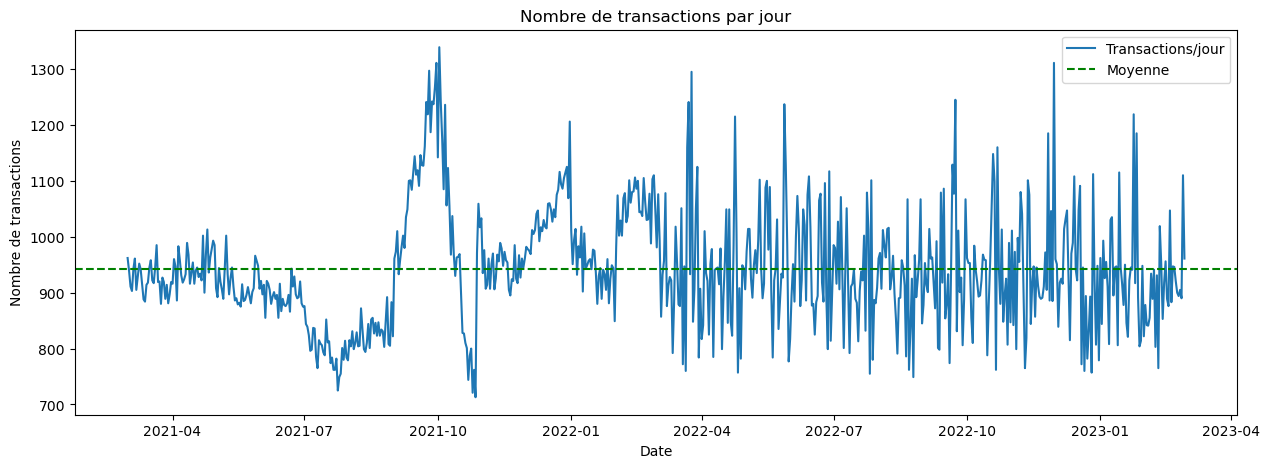

/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_82583/1986231540.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.to_period('M')  # ex: 2025-09


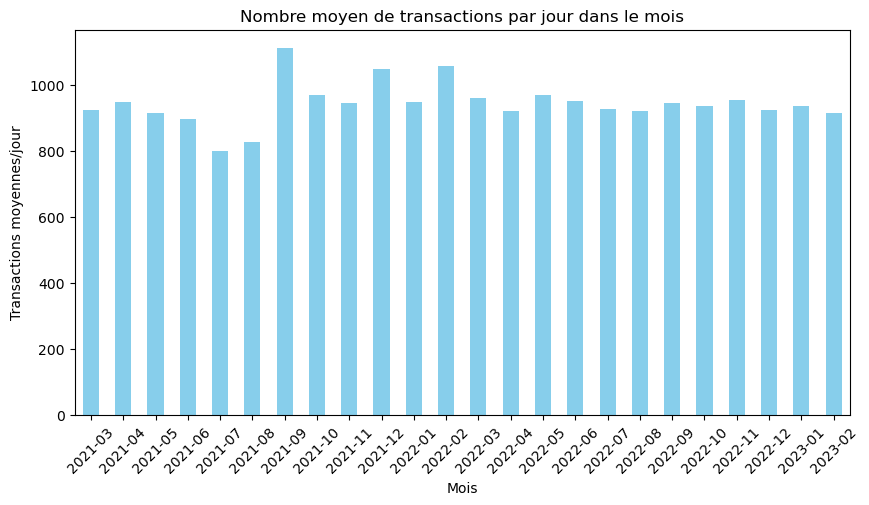

In [136]:
# Suppose que ton DataFrame s'appelle Interm
df = Interm_clean

# Créer une colonne pour la date sans l'heure si besoin
df['date_only'] = df['date'].dt.date

# Grouper par jour pour compter le nombre de transactions
transactions_journalieres = df.groupby('date_only').size()

# Calcul des statistiques par jour
min_tx = transactions_journalieres.min()
max_tx = transactions_journalieres.max()
mean_tx = transactions_journalieres.mean()

print(f"Min transactions/jour: {min_tx}")
print(f"Max transactions/jour: {max_tx}")
print(f"Moyenne transactions/jour: {mean_tx:.2f}")

# Graphique nombre de transactions par jour
plt.figure(figsize=(15,5))
plt.plot(transactions_journalieres.index, transactions_journalieres.values, label='Transactions/jour')
plt.axhline(mean_tx, color='green', linestyle='--', label='Moyenne')
plt.title("Nombre de transactions par jour")
plt.xlabel("Date")
plt.ylabel("Nombre de transactions")
plt.legend()
plt.show()

# Histogramme mensuel : nombre moyen de transactions par jour dans le mois
df['month'] = df['date'].dt.to_period('M')  # ex: 2025-09
transactions_mensuelles = df.groupby('month').size() / df.groupby('month')['date_only'].nunique()

plt.figure(figsize=(10,5))
transactions_mensuelles.plot(kind='bar', color='skyblue')
plt.title("Nombre moyen de transactions par jour dans le mois")
plt.xlabel("Mois")
plt.ylabel("Transactions moyennes/jour")
plt.xticks(rotation=45)
plt.show()

In [52]:
# CA total:
ca_tot = Complet_df.loc[(Complet_df["client_id"] != "NaN"),"price"].sum()
ventes_tot = Ventes_df["session_id"].count()

print("Le chiffre d'affaires total est de", ca_tot, "€")
print("pour un total de", ventes_tot, "ventes.")

Le chiffre d'affaires total est de 12028458.379999999 €
pour un total de 687534 ventes.


In [54]:
# CA annuel:
ca_annuel = Ventes_df.groupby(["year"])["price"].sum()
print("Chiffres d'affaires annuels:\n", ca_annuel)

# Nombre de ventes annuel:
ventes_annuelles = Ventes_df.groupby(["year"])["session_id"].count()
print("Nombre de ventes annuelles:\n", ventes_annuelles)

Chiffres d'affaires annuels:
 year
2021   4944760.98
2022   6108681.81
2023    974220.31
Name: price, dtype: float64
Nombre de ventes annuelles:
 year
2021    286671
2022    346380
2023     54483
Name: session_id, dtype: int64


In [56]:
print(Complet_df["date"].nlargest(1))

149718   2023-02-28 23:58:30.792755
Name: date, dtype: datetime64[ns]


2022 est donc notre meilleure année en matière de chiffre d'affaires et de nombre de ventes jusqu'à maintenant, cependant les données de 2023 ne sont pas complètes, la dernière session datant du 28 février à 23h58. Il faudrait donc comparer mensuellement plutôt pour voir si la situation en février 2023 est meilleure que les années précédentes pour la même période. La représentation graphique n'est pas nécessaire ici.

Text(0.5, 1.0, "Evolution mensuelle du chiffre d'affaires")

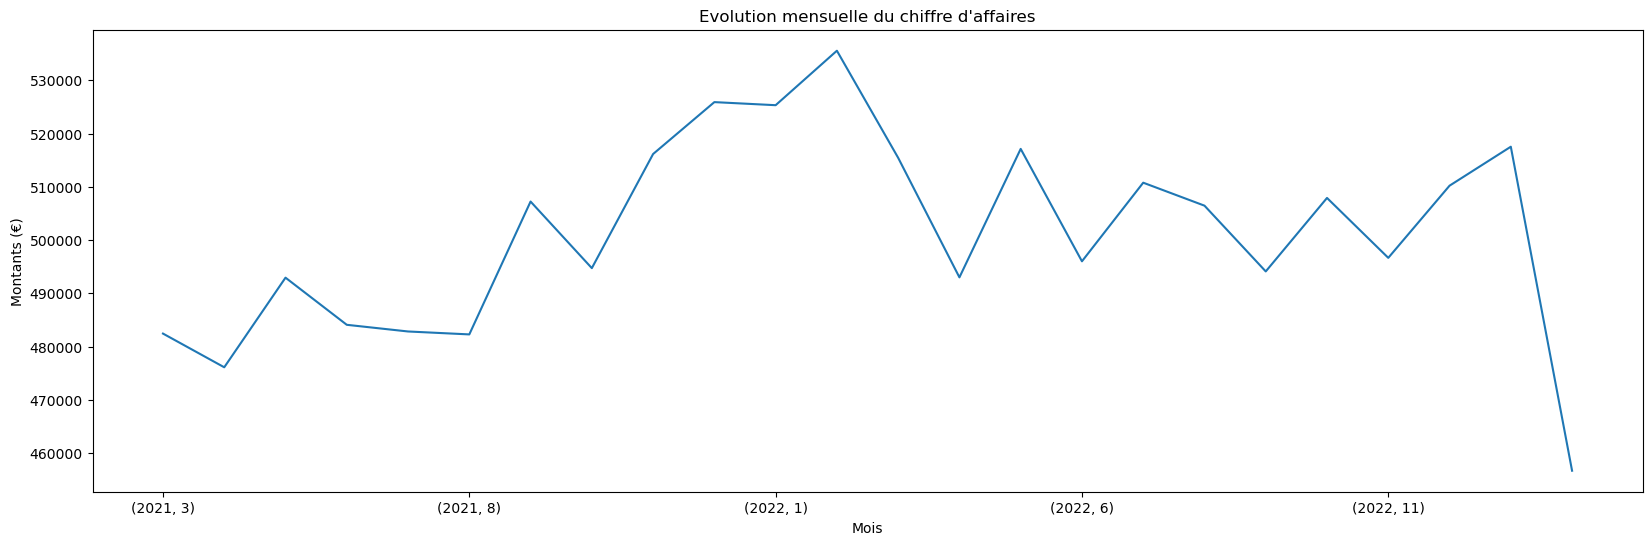

In [59]:
# CA mensuel:
Ventes_df = Ventes_df.sort_values(["date"],ascending=True)
ca_mensu = Ventes_df.groupby(["year","month"])["price"].sum()

# Nombre de ventes mensuelles:
ventes_mensu = Ventes_df.groupby(["year", "month"])["session_id"].count()

# Graphique:
plt.figure(figsize = (20,6))
ca_mensu.plot()
plt.xlabel("Mois")
plt.ylabel("Montants (€)")
plt.title("Evolution mensuelle du chiffre d'affaires")

In [60]:
ventes_tot = Ventes_df["session_id"].count()

nb_2021 = Ventes_df.loc[Ventes_df["year"] == 2021,"session_id"].count()
print("Nombre de transactions en 2021 :", nb_2021)

nb_2022 = Ventes_df.loc[Ventes_df["year"] == 2022,"session_id"].count()
print("Nombre de transactions en 2022 :", nb_2022)

nb_2023 = Ventes_df.loc[Ventes_df["year"] == 2023,"session_id"].count()
print("Nombre de transactions en 2021 :", nb_2023)

Nombre de transactions en 2021 : 286671
Nombre de transactions en 2022 : 346380
Nombre de transactions en 2021 : 54483


In [62]:
Ventes_df

somme_2021 = Ventes_df.loc[Ventes_df["year"] == 2021, "price"].sum()

print("Somme des ventes en 2021 :", somme_2021)

somme_2022 = Ventes_df.loc[Ventes_df["year"] == 2022, "price"].sum()

print("Somme des ventes en 2022 :", somme_2022)

somme_2023 = Ventes_df.loc[Ventes_df["year"] == 2023, "price"].sum()

print("Somme des ventes en 2023 :", somme_2023)

Somme des ventes en 2021 : 4944760.980000001
Somme des ventes en 2022 : 6108681.810000002
Somme des ventes en 2023 : 974220.31


In [65]:
# Creation d'un dataframe specifique par categories avec fonction d'agregation:
MensAg_df = Ventes_df[["categ", "price", "year", "month"]]
MensAg_df = pd.pivot_table(MensAg_df, index=["year","month"], columns=["categ"], aggfunc=["sum", "count"]).reset_index()
MensAg_df.columns = ["year", "month", "categ_0", "categ_1", "categ_2", "vol_categ_0", "vol_categ_1", "vol_categ_2"]

Text(0.5, 1.0, 'évolution mensuelle du volume de vente par catégorie')

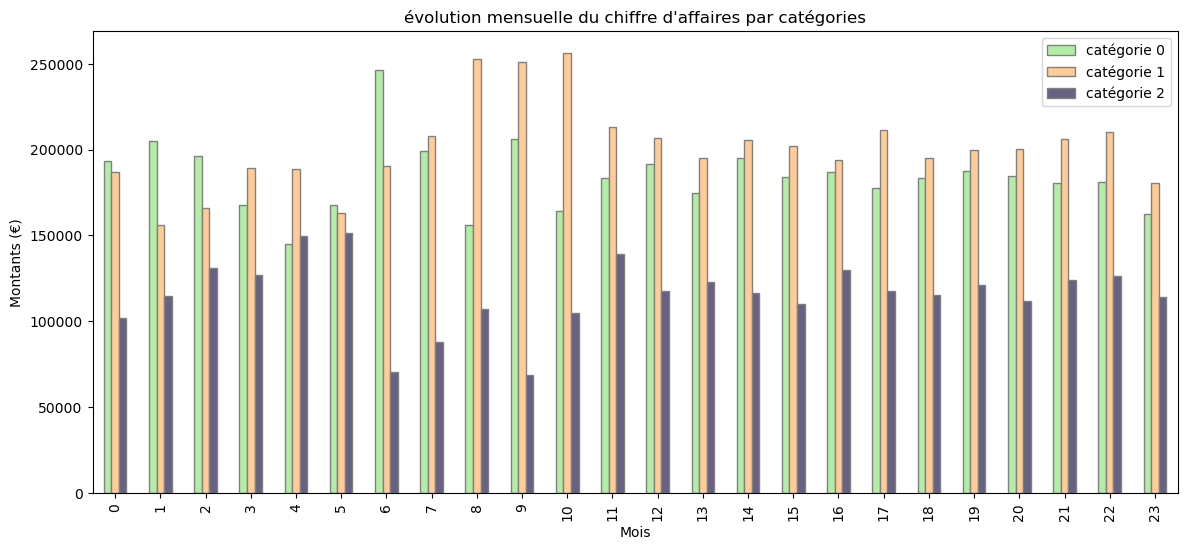

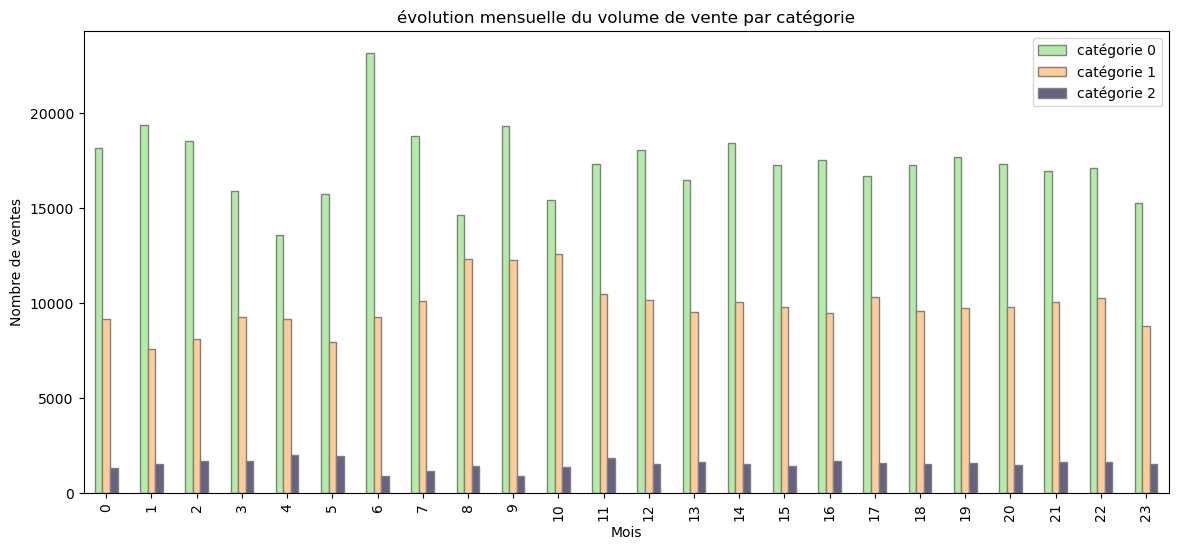

In [67]:
# Graphique CA par mois:
MensAg_df[["categ_0", "categ_1", "categ_2"]].plot.bar(figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)
plt.legend(["catégorie 0", "catégorie 1", "catégorie 2"])
plt.xlabel("Mois")
plt.ylabel("Montants (€)")
plt.title("évolution mensuelle du chiffre d'affaires par catégories")

# Graphique volume des ventes:
MensAg_df[["vol_categ_0", "vol_categ_1", "vol_categ_2"]].plot.bar(figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)
plt.legend(["catégorie 0", "catégorie 1", "catégorie 2"])
plt.xlabel("Mois")
plt.ylabel("Nombre de ventes")
plt.title("évolution mensuelle du volume de vente par catégorie")

In [68]:
# Modification du dataframe specifique par categories avec fonction d'agregation:
MensAg_df = Ventes_df[["categ", "price", "year", "month", "day"]]
MensAg_df = pd.pivot_table(
    MensAg_df,
    index=["year", "month", "day"],
    columns=["categ"],
    aggfunc={"price": ["sum", "count"]}
).reset_index()

# Renommer les colonnes pour plus de clarté
MensAg_df.columns = ["year", "month", "day",
                     "categ_0", "categ_1", "categ_2",
                     "vol_categ_0", "vol_categ_1", "vol_categ_2"]

# Nombre de ventes journalieres moyennes par mois
ventes_jour = MensAg_df.groupby(["year","month"])[["vol_categ_0", "vol_categ_1", "vol_categ_2"]].mean()

print(ventes_jour)

            vol_categ_0  vol_categ_1  vol_categ_2
year month                                       
2021 3          6246.10      6031.42      3285.07
     4          6840.75      5204.61      3824.95
     5          6328.60      5351.40      4221.40
     6          5598.10      6305.40      4232.78
     7          4669.38      6081.40      4824.56
     8          5410.89      5257.79      4888.90
     9          8211.80      6353.79      2342.43
     10         6427.45      6699.89      2831.79
     11         5196.99      8430.35      3578.26
     12         6646.33      8097.64      2221.11
2022 1          5297.11      8266.71      3382.60
     2          6542.76      7611.45      4973.34
     3          6176.29      6660.81      3790.53
     4          5833.24      6508.80      4091.26
     5          6286.20      6630.08      3765.41
     6          6131.16      6730.40      3672.31
     7          6035.39      6257.09      4184.40
     8          5721.70      6818.07      3797.88


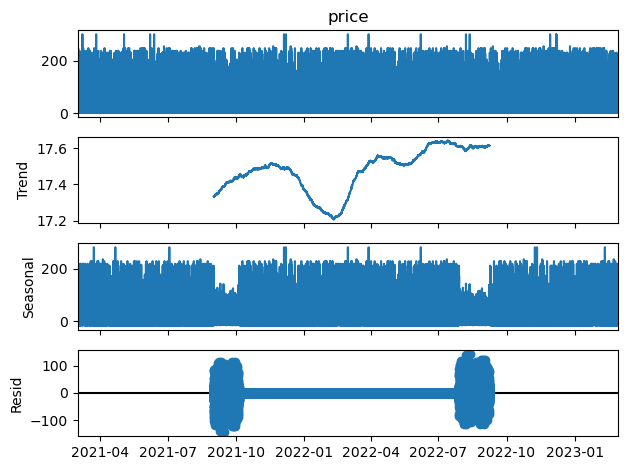

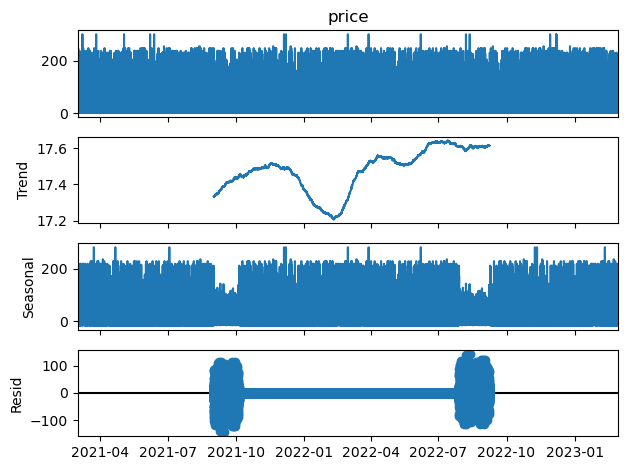

In [71]:
# Saisonnalite et tendance:
Ventes_df.reset_index(inplace=True)
Ventes_df["date"] = pd.to_datetime(Ventes_df["date"])
Ventes_df = Ventes_df.set_index("date")

sm.tsa.seasonal_decompose(Ventes_df["price"],period=325000).plot()

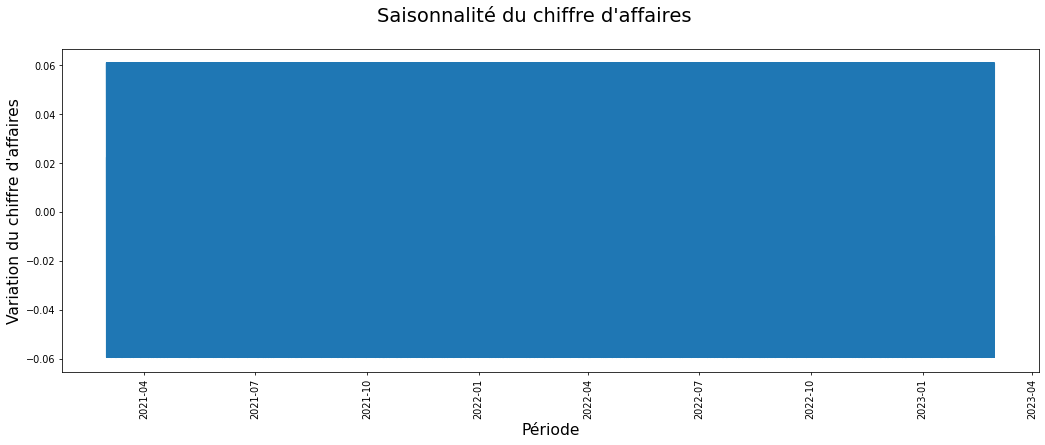

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
s=sm.tsa.seasonal_decompose(Ventes_df.price, period=6, extrapolate_trend=1)
#s.resid
s.seasonal
s.trend

# Graphique:
plt.figure(figsize = (18,6), dpi=70).suptitle("Saisonnalité du chiffre d'affaires", fontsize=20)
plt.plot(s.seasonal)
plt.xticks(rotation=90)
plt.xlabel("Période", fontsize=16)
plt.ylabel("Variation du chiffre d'affaires", fontsize=16)
plt.show()

In [140]:
ca_mensu

year  month
2021  3       482440.61
      4       476109.30
      5       492943.47
      6       484088.56
      7       482835.40
      8       482284.79
      9       507240.68
      10      494733.16
      11      516167.73
      12      525917.28
2022  1       525338.99
      2       535571.50
      3       515456.53
      4       492998.94
      5       517132.60
      6       496016.12
      7       510783.12
      8       506467.27
      9       494114.53
      10      507917.77
      11      496664.94
      12      510219.50
2023  1       517540.55
      2       456679.76
Name: price, dtype: float64

In [73]:
# Autocorrelation
autocor = np.corrcoef(np.array([Ventes_df["price"][:-1], Ventes_df["price"][1:]]))
print(autocor)

[[ 1.         -0.00270503]
 [-0.00270503  1.        ]]


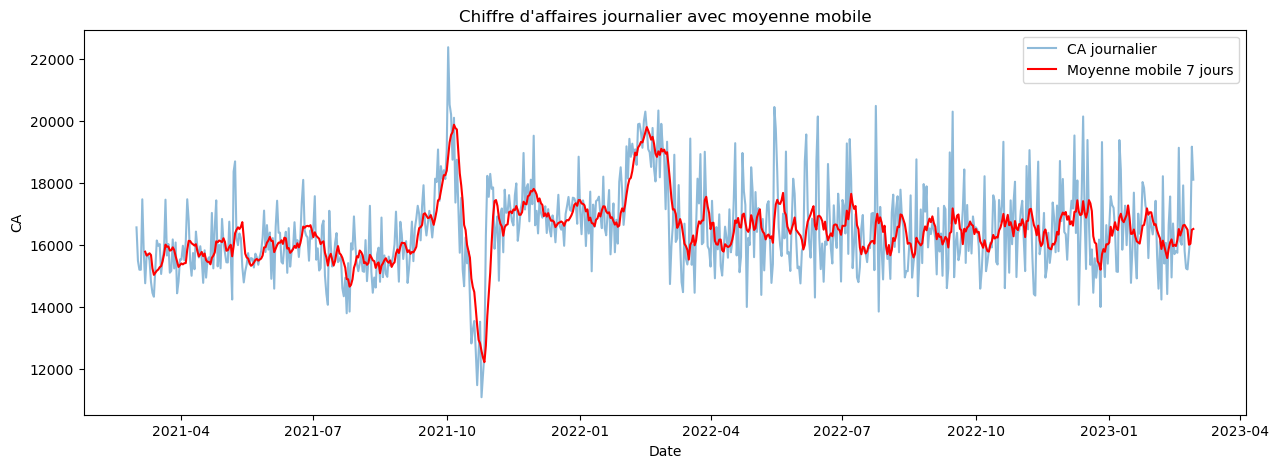

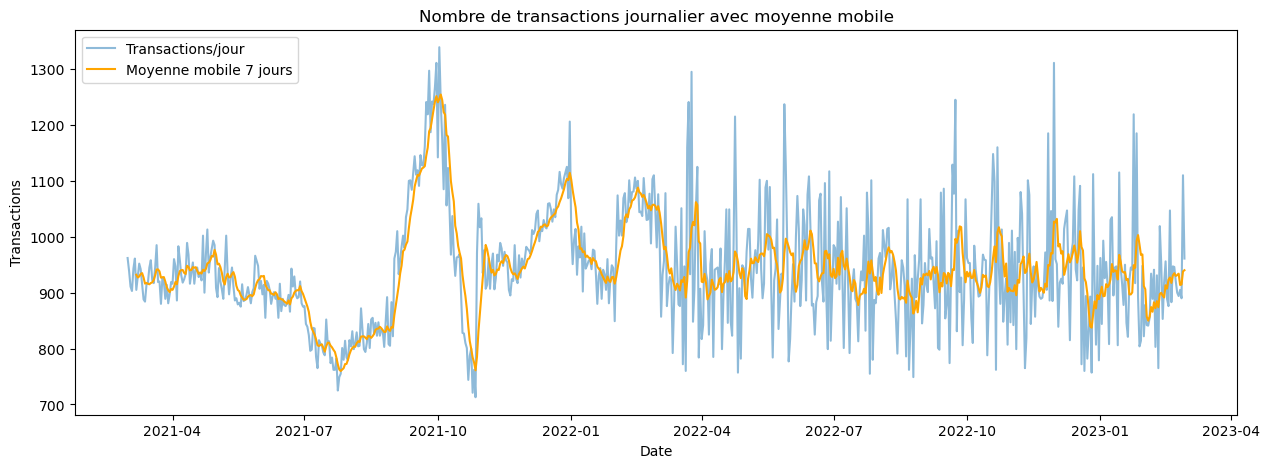

In [154]:
# -------------------------------
# 1️⃣ Créer la colonne date à partir de year, month, day
# -------------------------------
Ventes_df['date_only'] = pd.to_datetime(Ventes_df[['year','month','day']])

# -------------------------------
# 2️⃣ Calcul journalier
# -------------------------------
# Chiffre d'affaires journalier
ca_journalier = Ventes_df.groupby('date_only')['price'].sum()

# Nombre de transactions journalier
transactions_journalieres = Ventes_df.groupby('date_only').size()

# Moyenne mobile sur 7 jours
ca_journalier_mm = ca_journalier.rolling(window=7).mean()
transactions_journalieres_mm = transactions_journalieres.rolling(window=7).mean()

# -------------------------------
# 3️⃣ Graphiques
# -------------------------------
plt.figure(figsize=(15,5))
plt.plot(ca_journalier.index, ca_journalier, label='CA journalier', alpha=0.5)
plt.plot(ca_journalier_mm.index, ca_journalier_mm, color='red', label='Moyenne mobile 7 jours')
plt.title("Chiffre d'affaires journalier avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("CA")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(transactions_journalieres.index, transactions_journalieres, label='Transactions/jour', alpha=0.5)
plt.plot(transactions_journalieres_mm.index, transactions_journalieres_mm, color='orange', label='Moyenne mobile 7 jours')
plt.title("Nombre de transactions journalier avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.show()

Zoom sur les références:
---

In [78]:
# Meilleures et pires ventes:
nbr_ventes_ref = Ventes_df.groupby(["id_prod"])["session_id"].count()

print("Références les plus vendues")
print(nbr_ventes_ref.nlargest(10))
print("Références les moins vendues")
print(nbr_ventes_ref.nsmallest(10))

Références les plus vendues
id_prod
1_369    2340
1_417    2269
1_414    2246
1_498    2202
1_425    2163
1_403    2040
1_413    2036
1_412    2014
1_406    2003
1_407    2001
Name: session_id, dtype: int64
Références les moins vendues
id_prod
0_1151    1
0_1284    1
0_1379    1
0_1498    1
0_1539    1
0_1601    1
0_1633    1
0_1683    1
0_1728    1
0_2201    1
Name: session_id, dtype: int64


Nos 10 best sellers appartiennent tous à la catégorie 1 tandis que les dix pires ventes hors des 21 produits non vendus appartiennent à la catégorie 0.

indice de Gini: 0.695


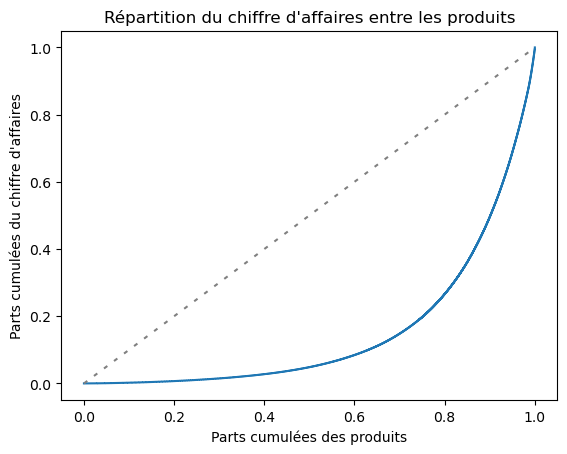

In [80]:
# Courbe de Lorentz: (Repartition du CA par produits)
lorenz_CA_prod = np.cumsum(np.sort(nbr_ventes_ref)) / nbr_ventes_ref.sum()
lorenz_CA_prod = np.append([0], lorenz_CA_prod)
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), lorenz_CA_prod, drawstyle='steps-post'),
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), np.linspace(0,1,len(lorenz_CA_prod)),color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des produits")
plt.title("Répartition du chiffre d'affaires entre les produits")
aire_ss_courbe_CA_prod = lorenz_CA_prod[:-1].sum() / len(lorenz_CA_prod)
S_ca_prod = 0.5 - aire_ss_courbe_CA_prod
gini_CA_prod = 2* S_ca_prod
print("indice de Gini:",round(gini_CA_prod,3))

L'indice de Gini s'éloigne fortement de 0, le poids des produits dans le chiffre d'affaires global est donc très inégal.

Répartitions des références par catégories:
 categ
0    2308
1     739
2     239
Name: id_prod, dtype: int64
Nombre de ventes par catégories:
 categ
0.00    415459
1.00    235592
2.00     36483
Name: index, dtype: int64
Prix moyen d'un livre selon sa catégorie:
 categ
0    11.73
1    25.53
2   108.35
Name: price, dtype: float64
Chiffre d'affaires par catégorie
 categ
0.00   4419730.97
1.00   4827657.11
2.00   2780275.02
Name: price, dtype: float64


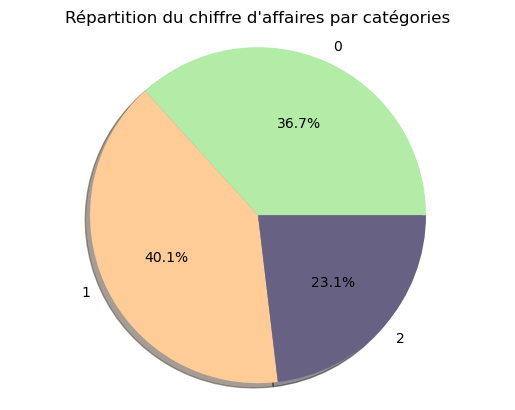

In [82]:
# Repartition des references parmis les categories:
repartition_categ = Products_df.groupby(["categ"])["id_prod"].count()
print("Répartitions des références par catégories:\n",repartition_categ)

# Volume de ventes par categories:
vol_categ = Ventes_df.groupby(["categ"])["index"].count()

print("Nombre de ventes par catégories:\n", vol_categ)

# Prix moyen par categories:
prix_categ = Products_df.groupby(["categ"])["price"].mean()
print("Prix moyen d'un livre selon sa catégorie:\n",prix_categ)

# CA par categories:
ca_categ = Ventes_df.groupby(Ventes_df["categ"])["price"].sum()
print("Chiffre d'affaires par catégorie\n",ca_categ)

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(ca_categ,
        labels=["0","1","2"],
        autopct="%1.1f%%",
        colors=colors,
        shadow=True)
ax1.axis("equal")
plt.title("Répartition du chiffre d'affaires par catégories")
plt.show()

Différences de prix marquées, en particulier pour les livres de la catégorie 2. On note également que nos meilleures ventes se font sur la catégorie 1 qui est la catégorie intermédiaire en prix moyen.

Profils clients
---

In [86]:
# Meilleurs clients:
best_client = Ventes_df.groupby(["client_id"])["price"].sum()

print("Clients ayant le plus dépensé")
print(best_client.nlargest(10))

Clients ayant le plus dépensé
client_id
c_1609   326039.89
c_4958   290227.03
c_6714   153918.60
c_3454   114110.57
c_1570     5285.82
c_3263     5276.87
c_2140     5260.18
c_2899     5214.05
c_7319     5155.77
c_7959     5135.75
Name: price, dtype: float64


c_1609, (homme 41ans) achète plusieurs fois les mêmes livres, il peut s'agir d'un revendeur (libraires, bibliothécaires), les trois autres aussi d'ailleurs.
Il est possible de proposer un accompagnement presonnalisé à ces clients puisqu'ils n'auront pas les mêmes besoins que des particuliers.

In [90]:
# Nombre d'achats et montant moyen par client:
nbr_achats_moy = Complet_df.groupby(["client_id"])["session_id"].count().mean()
montant_achats_moy = Ventes_df.groupby(["client_id"])["price"].sum().mean()

print("Le nombre moyen d'achat par client depuis l'ouverture de notre site est", round(nbr_achats_moy,2))
print("Le montant moyen d'achat par client depuis l'ouverture de notre site est", round(montant_achats_moy,2))

Le nombre moyen d'achat par client depuis l'ouverture de notre site est 79.75
Le montant moyen d'achat par client depuis l'ouverture de notre site est 1398.57


indice de Gini: 0.442


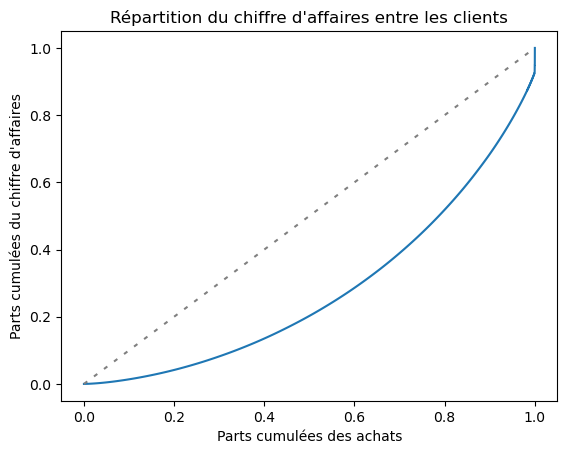

In [94]:
# Courbe de Lorentz: (repartition du CA par clients)
lorenz_CA_client = np.cumsum(np.sort(best_client)) / best_client.sum()
lorenz_CA_client = np.append([0], lorenz_CA_client)
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), lorenz_CA_client, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), np.linspace(0,1,len(lorenz_CA_client)), color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client = lorenz_CA_client[:-1].sum() / len(lorenz_CA_client)
S_ca_client = 0.5 - aire_ss_courbe_CA_client
gini_CA_client = 2*S_ca_client
print("indice de Gini:",round(gini_CA_client,3))

In [98]:
# Nombre moyen d'achats par sessions:
print("Il y a eu",
      Complet_df["session_id"].nunique(),
      "sessions")

print("Une session aboutie en moyenne à",
      round(Complet_df.groupby(["session_id","client_id"])["id_prod"].count().mean(),2),
      "achats")

Il y a eu 345505 sessions
Une session aboutie en moyenne à 1.99 achats


Il y a 342 315 sessions pour un total de 679 332 transactions, il est donc courant d'avoir plusieurs transactions par sessions.
En moyenne une session aboutie sur 1,98 achats.

Analyse ciblée clients:
===

sex
f    4490
m    4131
Name: client_id, dtype: int64


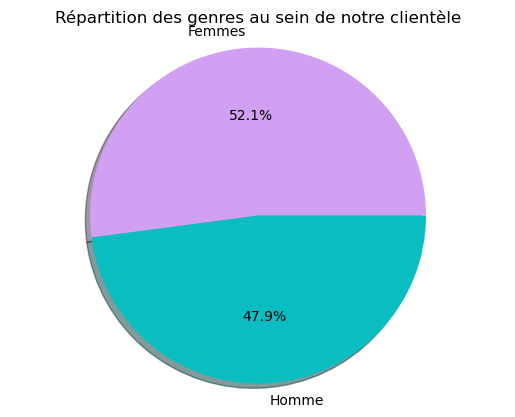

In [103]:
# Repartition des genres parmis nos clients:
repartition_genre = Customers_df.groupby(["sex"])["client_id"].count()
print(repartition_genre)

# Graphique:
fig2, ax2 = plt.subplots()
ax2.pie(repartition_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax2.axis("equal")
plt.title("Répartition des genres au sein de notre clientèle")
plt.show()

montant total des achats par genre:
 sex
f   5950843.68
m   6076819.42
Name: price, dtype: float64
nombre total d'achats par genre:
 sex
f    342693
m    344841
Name: price, dtype: int64
montant moyen des achats par genre:
 sex
f   17.36
m   17.62
Name: price, dtype: float64


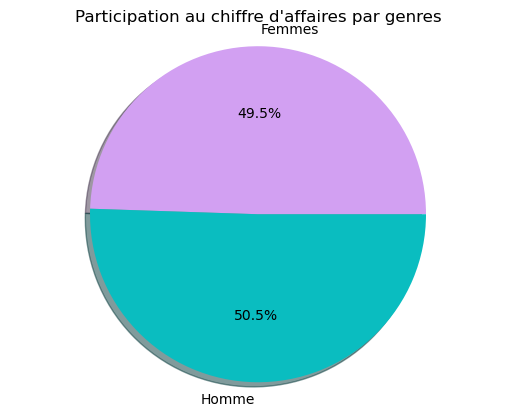

In [105]:
# Depenses par genres:
repartition_achats_genre = Ventes_df.groupby(["sex"])["price"].sum()
print("montant total des achats par genre:\n", repartition_achats_genre)

nbr_achats_genre = Ventes_df.groupby(["sex"])["price"].count()
print("nombre total d'achats par genre:\n", nbr_achats_genre)

moy_achats_genre = Ventes_df.groupby(["sex"])["price"].mean()
print("montant moyen des achats par genre:\n", moy_achats_genre)


# Graphique:
fig3, ax3 = plt.subplots()
ax3.pie(repartition_achats_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax3.axis("equal")
plt.title("Participation au chiffre d'affaires par genres")
plt.show()

In [107]:
# Table de contingence pour Chi²:
categ_sex = pd.crosstab(Ventes_df["sex"],Ventes_df["categ"])
print(categ_sex)

# Chi²:
cs_chi2, cs_p, cs_dof, cs_exp = st.chi2_contingency(categ_sex)

print("Les fréquences théoriques sont:\n", cs_exp,3)
print(f"Ce qui donne un X² de {cs_chi2:.3f} à", cs_dof, "ddl")
print(f"soit une p-value de", cs_p)

# Calcul V de Cramer:
n_cs = len(Ventes_df)
minDim_cs = min(categ_sex.shape)-1

V_cs = np.sqrt((cs_chi2/n_cs) / minDim_cs)

print("Le V de Cramer vaux:", V_cs)

categ    0.00    1.00   2.00
sex                         
f      206103  119307  17283
m      209356  116285  19200
Les fréquences théoriques sont:
 [[207080.50959953 117427.98066132  18184.50973915]
 [208378.49040047 118164.01933868  18298.49026085]] 3
Ce qui donne un X² de 158.254 à 2 ddl
soit une p-value de 4.3205822283997063e-35
Le V de Cramer vaux: 0.015171569112675852


L'hypothèse nulle est ici l'indépendance des variables catégories achetées et genre.
Dans tous les cas que l'on prenne un seuil à 5% (0,05) ou 1% (0,01), la p-value sera ici toujours très inférieure au seuil de significativité, l'hypothèse nulle est rejetée, les catégories des livres achetées ne dépendent donc pas du genre de l'acheteur.

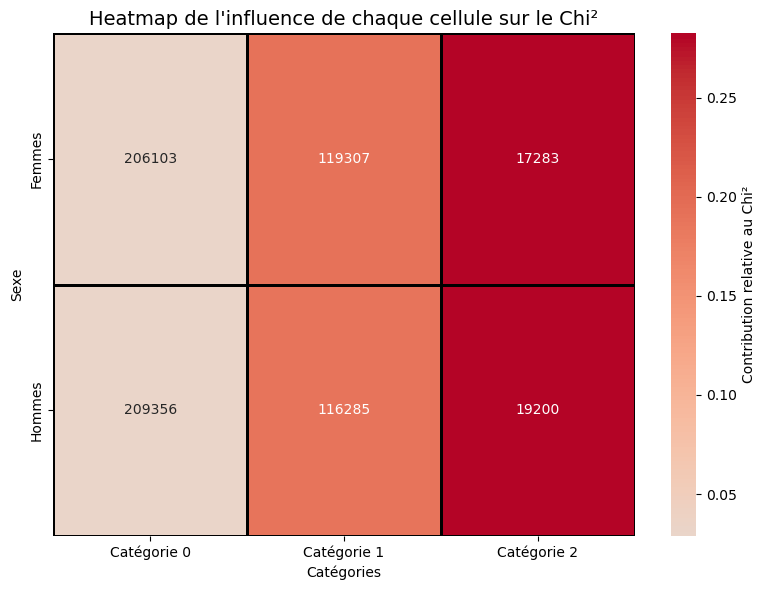

In [116]:


# Supposons que tu as :
# categ_sex : tableau observé
# cs_exp : tableau attendu
# cs_chi2 : valeur totale du Chi²

# Calcul de l'influence de chaque cellule
len_i = categ_sex.shape[0]
len_j = categ_sex.shape[1]
xij = np.zeros((len_i, len_j))
for i in range(len_i):
    for j in range(len_j):
        xij[i,j] = (categ_sex.values[i,j]-cs_exp[i,j])**2 / cs_exp[i,j]

# Proportion par rapport au Chi² total
influence = xij / cs_chi2

# Convertir en DataFrame pour seaborn
influence_df = pd.DataFrame(influence, 
                            index=["Femmes","Hommes"],
                            columns=["Catégorie 0", "Catégorie 1", "Catégorie 2"])

# Heatmap améliorée
plt.figure(figsize=(8,6))
sns.heatmap(influence_df, 
            annot=categ_sex,          # afficher les valeurs observées
            fmt='d',                  # format entier
            cmap='coolwarm',          # palette de couleurs
            linewidths=1,             # lignes entre cellules
            linecolor='black',        # couleur des lignes
            cbar_kws={'label':'Contribution relative au Chi²'},  # légende de la couleur
            center=0)                 # centrer la palette sur 0 pour contraste

plt.title("Heatmap de l'influence de chaque cellule sur le Chi²", fontsize=14)
plt.ylabel("Sexe")
plt.xlabel("Catégories")
plt.tight_layout()
plt.show()

[]

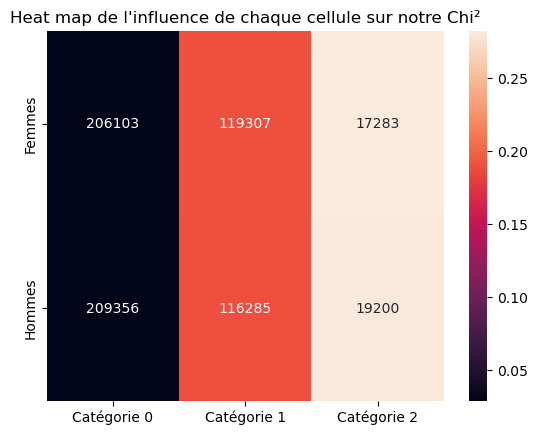

In [112]:
# Heat map pour identifier les cellules les plus influantes sur le Chi²:
len_i = categ_sex.shape[0]
len_j = categ_sex.shape[1]
xij = np.zeros((len_i, len_j))
for i in range(len_i):
    for j in range(len_j):
        xij[i,j] = (categ_sex.values[i,j]-cs_exp[i,j])**2 / cs_exp[i,j]

sns.heatmap(xij/cs_chi2,
            annot=categ_sex,
            fmt='d',
            yticklabels=["Femmes","Hommes"],
            xticklabels=["Catégorie 0", "Catégorie 1", "Catégorie 2"])
plt.title("Heat map de l'influence de chaque cellule sur notre Chi²")
plt.plot()

La map nous confirme qu'il n'y a que peu de variations entre genres au sein des catégories, l'achat d'une catégorie en particulier ne dépenderait donc pas du genre de l'acheteur.

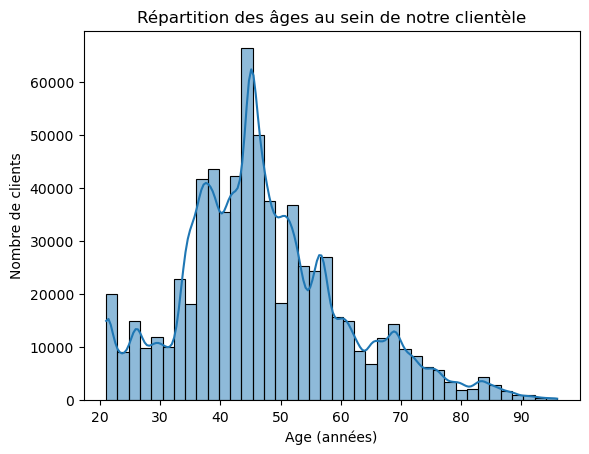

In [132]:
# Repartition des ages parmis nos clients:
sns.histplot(data=Complet_df["age"],
             bins=40,
             kde=True)
plt.title("Répartition des âges au sein de notre clientèle")
plt.ylabel("Nombre de clients")
plt.xlabel("Age (années)")
plt.show()

In [133]:
# Test de Normalite de la repartition des ages:
print(st.anderson(Customers_df["age"], dist="norm"))

AndersonResult(statistic=54.304839298933075, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=46.724393921818816, scale=16.917958031023538)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


On utilise le test d'Anderson Darling car il est non paramétrique et utilisé pour les grands échantillons.
H0 = les données suivent une distribution normale
alpha 1%
statistique du test d'Anderson (54) > valeure critique (1)
On rejette H0.
On considère que l'âge ne suit pas une distribution normale avec un risque d'erreure 1%

Autres tests possibles mais moins puissants/appropriés:
- print(st.shapiro(Customers_df["age"]))
- print(st.jarque_bera(Customers_df["age"]))
- print(st.kstest(Customers_df["age"], cdf="norm"))

In [137]:
# Ajout des tranches d'ages:
Ventes_df["age_range"] = pd.cut(x= Ventes_df["age"], bins=[0,30,60,110], include_lowest=False, ordered=True)

# Repartition des achats par tranches d'ages:
repartition_achats_age_range = Ventes_df.groupby(["age_range"])["price"].sum()
print("montant total des achats par tranches d'age:\n", repartition_achats_age_range)

# Nombre d'achats par tranches d'ages:
nbr_achats_age_range = Ventes_df.groupby(["age_range"])["price"].count()
print("nombre total d'achats par tranches d'age:\n",nbr_achats_age_range)

# Motant moyen des achats par tranches d'ages:
moy_achats_age_range = Ventes_df.groupby(["age_range"])["price"].mean()
print("montant moyen des achats par tranches d'age:\n", moy_achats_age_range)

montant total des achats par tranches d'age:
 age_range
(0, 30]     2709584.63
(30, 60]    7523791.77
(60, 110]   1794286.70
Name: price, dtype: float64
nombre total d'achats par tranches d'age:
 age_range
(0, 30]       65833
(30, 60]     515082
(60, 110]    106619
Name: price, dtype: int64
montant moyen des achats par tranches d'age:
 age_range
(0, 30]     41.16
(30, 60]    14.61
(60, 110]   16.83
Name: price, dtype: float64


/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_33568/2874232711.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  repartition_achats_age_range = Ventes_df.groupby(["age_range"])["price"].sum()
/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_33568/2874232711.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nbr_achats_age_range = Ventes_df.groupby(["age_range"])["price"].count()
/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_33568/2874232711.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

Bien que les moins de 30 ans dépensent plus en moyenne par achats ils nous rapportent moins que les 30- 60 ans qui font beaucoup plus d'achats sur notre site et donc nous rapportent plus en terme de chiffre brut. Cela est très probablement dû à leur sur représentation au sein de nontre base de clientèle. Il serait intéressant de cibler pour les prochaines campagnes marketing les moins de 30 ans afin d'en augmenter le nombre parmi notre clientèle.

Corrélation de Speraman: SignificanceResult(statistic=-0.8583732057416268, pvalue=3.805937971547995e-23)


Text(0.5, 1.0, 'Motant des achats par âges')

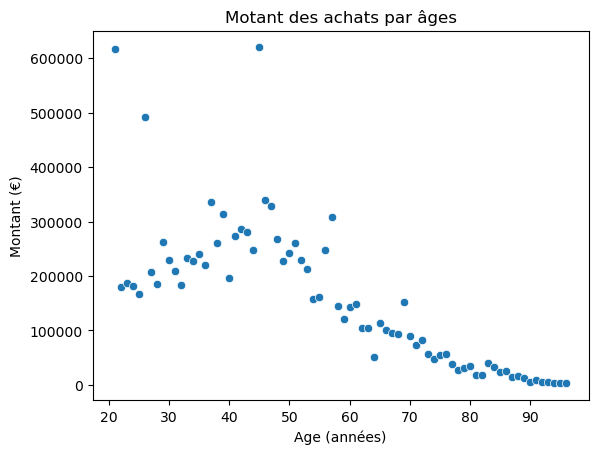

In [140]:
# Lien entre l'age et le montant des achats:
age = Ventes_df.groupby(["age"])["client_id"].count()
tot_achats_age = Ventes_df.groupby(["age"])["price"].sum()

# Correlation entre l'age et le montant total des achats:
print("Corrélation de Speraman:", st.spearmanr(tot_achats_age.index, tot_achats_age.values))

# Graphique:
sns.scatterplot(data= tot_achats_age)
plt.ylabel("Montant (€)")
plt.xlabel("Age (années)")
plt.title("Motant des achats par âges")

Les ages ne suivent pas une distribution Normale, le test est forcément non pramétrique, on utilise donc un test de corrélation de Spearman.

Corrélation de Speraman: SignificanceResult(statistic=-0.6864251537935748, pvalue=7.681961967076513e-12)


Text(0.5, 1.0, "Nombre d'achats selon l'âge")

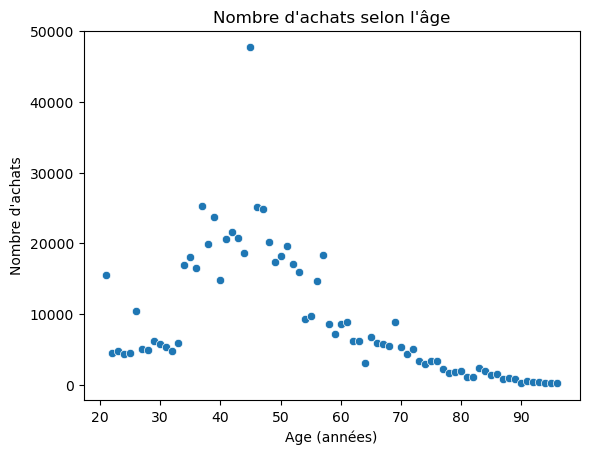

In [143]:
# Lien entre l'age et la taille du panier:
nbr_achats_age = Ventes_df.groupby(["age"])["session_id"].count()

# Correlation entre l'age et le montant total des achats:
print("Corrélation de Speraman:", st.spearmanr(nbr_achats_age.index,nbr_achats_age.values))

# Graphique:
sns.scatterplot(data= nbr_achats_age)
plt.ylabel("Nombre d'achats")
plt.xlabel("Age (années)")
plt.title("Nombre d'achats selon l'âge")

/var/folders/76/qdqn_yqn10bg_179q5pd3s480000gn/T/ipykernel_33568/2371566677.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


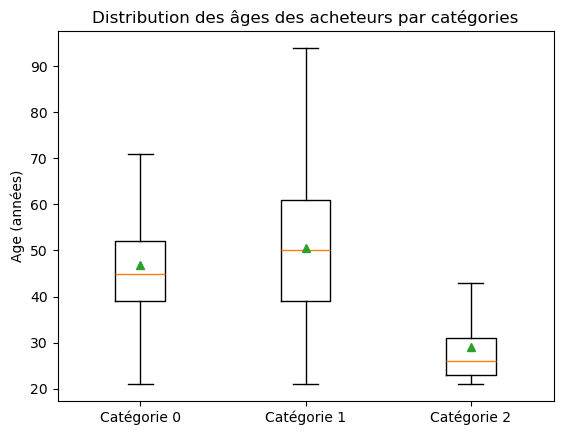

In [145]:
# Categories les plus achetees par age:
categ = Ventes_df["categ"].unique()
categ_age = {categ: Ventes_df.loc[Ventes_df["categ"]==categ, "age"] for categ in categ}

# Graphique:
plt.boxplot([
    categ_age[0],
    categ_age[1],
    categ_age[2]]
    ,labels=["Catégorie 0", "Catégorie 1", "Catégorie 2"],showmeans=True, showfliers=False)
plt.ylabel("Age (années)")
plt.title("Distribution des âges des acheteurs par catégories")
plt.show()

In [147]:
# Lien entre age et categorie achetees:
print(type(categ_age[0].values))
print(st.kruskal(categ_age[0], categ_age[1], categ_age[2]))

<class 'numpy.ndarray'>
KruskalResult(statistic=78458.43837285662, pvalue=0.0)


Le test de Kruskal Wallis, est non paramétrique, les groupes doivent contenir plus de cinq individus. p-val < 0,01 on rejette l'hypothèse nulle selon laquelle il n'y aurait pas de différence entre l'âge median d'achat par catégorie.
Kruskal est un test de rang.

age
21   635.58
22   206.08
23   203.78
24   182.55
25   193.68
      ...  
92    15.14
93    11.42
94     6.61
95     8.45
96     6.48
Name: session_id, Length: 76, dtype: float64
Corrélation de Speraman: SignificanceResult(statistic=0.2041035000469351, pvalue=1.6483221326747356e-81)


Text(0.5, 1.0, "Fréquence mensuelle d'achat par âge")

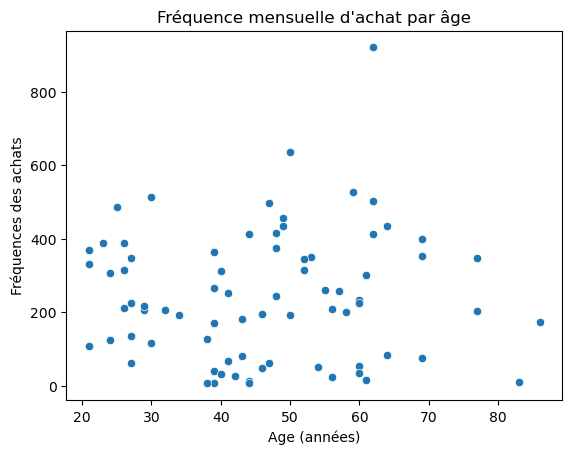

In [150]:
# Frequence d'achat mensuelle:
freq_mensu= Ventes_df.groupby(["client_id", "year", "month"])["session_id"].nunique().groupby(["client_id"]).mean().reset_index()

# Ajout des ages au df frequence mensuelle:
freq_mensu = pd.merge(Customers_df, freq_mensu, on="client_id",how="outer")
freq_mensu = freq_mensu.dropna()                                                #On enleve les clients non acheteurs

# Lien entre l'age et la frequence d'achat mensuelle:
freq_age = freq_mensu.groupby(["age"])["session_id"].sum()

print(freq_age)

# Ces lignes peuvent être ajoutees ou retirees pour avoir la correlation et le scatterplot en prennant en compte les libraires:
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_1609")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_3454")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_4958")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_6714")].index, inplace=True)

# Correlation entre l'age et le montant total des achats
print("Corrélation de Speraman:", st.spearmanr(freq_mensu["age"], freq_mensu["session_id"]))

# Graphique
sns.scatterplot(x=freq_mensu["age"], y=freq_age)
plt.ylabel("Fréquences des achats")
plt.xlabel("Age (années)")
plt.title("Fréquence mensuelle d'achat par âge")

#Rq: changer nom session_id par freq_m dans df freq_mensu

L'échelle ne va que jusqu'à 80 contrairement aux autres scatterplot mais les 90 et plus sont bien présents dans le dataframe.

Probabilité conditionnelle
---

Probabilité pour un client d’acheter la référence 0_525 sachant qu’il a acheté la référence 2_159 (*une probabilité conditionnelle est la probabilité de B sachant A. P(B|A) =P(A∩B) /P(A)*)
Notant :
A = le client à acheté la référence 2_159
B = le client à acheté la référence 0_525

P(A)= nombre d'achats de 2_159 / nombre d'achats totaux = 650/679332
P(B)= nombre d'achats de 0_525 / nombre d'achats totaux = 500/679332
P(A∩B)= nombre d'achats de 2_159 & 0_525 / nombre d'achats totaux = 499 / 679332

Les évènements sont indépendants ssi p(A∩B) = P(A) * P(B)

In [155]:
# Calcul des probabilites de base:
achat_2_159 = Ventes_df.loc[(Ventes_df["id_prod"] == "2_159"),"session_id"]
achat_0_525 = Ventes_df.loc[(Ventes_df["id_prod"] == "0_525"),"session_id"]

p_achat_2_159 = achat_2_159.count()/ventes_tot
p_achat_0_525 = achat_0_525.count()/ventes_tot
p_achat_2_159n_achat_0_525 = len(set(achat_2_159).intersection(set(achat_0_525)))/ventes_tot

print("P(A)=",p_achat_2_159)
print("P(B)=",p_achat_0_525)
print("P(A∩B)=",p_achat_2_159n_achat_0_525)

# L'achat des deux references est-il independant?
if p_achat_2_159n_achat_0_525==p_achat_2_159*p_achat_0_525:
    print("Les évenements sont indépendants")
else:
    print("Les évenements ne sont pas indépendants")

# Probabilite pour un client d’acheter la reference 0_525 sachants qu’il a achete la reference 2_159:
print("P(B|A)=", p_achat_2_159n_achat_0_525/p_achat_2_159)

P(A)= 0.0009454077907419851
P(B)= 0.0007272367621092193
P(A∩B)= 0.0007257822885850009
Les évenements ne sont pas indépendants
P(B|A)= 0.7676923076923077


P(A∩B) =/= P(A) x P(B), les deux achats ne sont donc pas indépendants (on le remarque facilement en comparant le nombre d'achats de 0_525 seul vs le nombre d'achats de 0_525 avec 2_159). La probabilité pour un client d'acheter 0_525 sachant qu'il a acheté 2_519 est forte (supérieure à 0,76).

On pourrait collecter dans notre pipeline la durée des sessions, plus d'informations sur les clients (catégorie socio-professionnelle, zone géographique, date de création de compte), sur les produits (catégories plus détaillées, date de sortie de l'ouvrage). Il faudrait également comparer le comportement en ligne et hors ligne, en particulier pour les clients utilisant les deux modes d'achats.